In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Import the training data

In [77]:
X = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
X.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Clean the data step-by-step

Convert cardinal data into ordinal form

In [79]:
# Fill missing values
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object']).columns

for col in num_cols:
    X[col] = X[col].fillna(X[col].mean())

for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode().iloc[0])

In [80]:
X["Transported"] = X["Transported"].astype(int)


In [81]:
y = X["Transported"]
X = X.drop(["Transported"], axis = 1)

In [82]:
# Name of the passengers has nothing to do with the disappearence
X = X.drop(["Name"], axis = 1)


In [83]:
X = X.drop(["PassengerId"], axis = 1)

# Explore the data

In [84]:
X["VIP"] = X["VIP"].astype(int)
p_correlation = X["VIP"].corr(y)
print(p_correlation)

-0.0372608322666151


Text(0.5, 1.0, 'Plot of VIPs Transported')

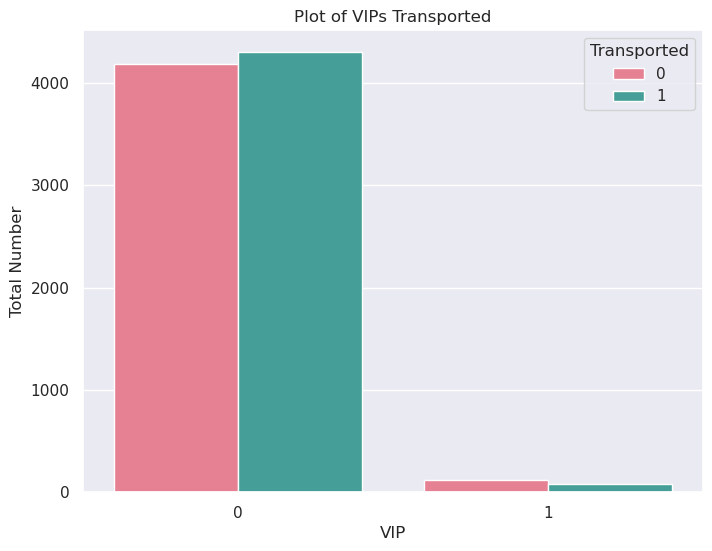

In [85]:
# Set the style of the seaborn plots to 'darkgrid'
sns.set(style='darkgrid')

# Create a new figure with a size of 8x6 inches
plt.figure(figsize=(8, 6)) 

# Create a countplot using the 'train' DataFrame, with 'VIP' on the x-axis and 'Transported' on the hue axis,
# and use the 'husl' color palette
sns.countplot(data=X, x='VIP', hue=y, palette='husl');

# Set the x-axis label to 'VIP'
plt.xlabel('VIP')

# Set the y-axis label to 'Total Number'
plt.ylabel('Total Number')

# Set the title of the plot 
plt.title('Plot of VIPs Transported')

There does not seem to be a significant correlation.
Question: Can we drop the VIP column for the final prediction?

In [86]:
X["CryoSleep"] = X["CryoSleep"].astype(int)

In [87]:
p_correlation = X["CryoSleep"].corr(y)
print(p_correlation)

0.46013235785425843


Text(0.5, 1.0, 'Plot of Transported v/s CryoSleep')

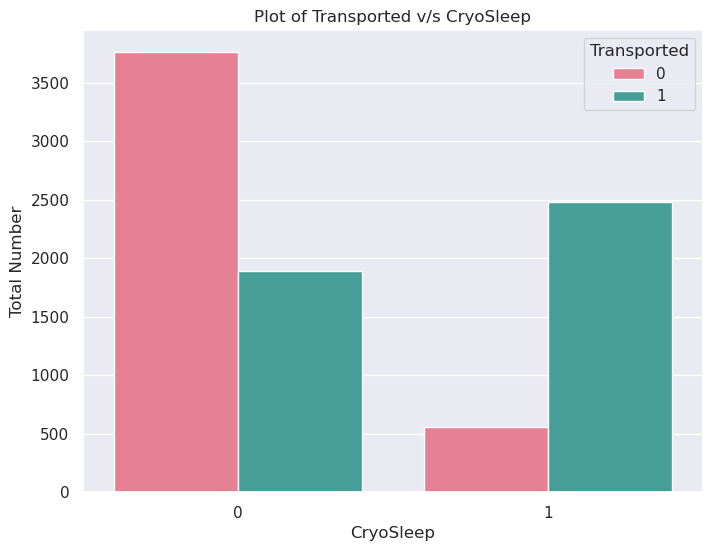

In [88]:
# Set the style of the seaborn plots to 'darkgrid'
sns.set(style='darkgrid')

# Create a new figure with a size of 8x6 inches
plt.figure(figsize=(8, 6)) 

# Create a countplot using the 'train' DataFrame, with 'VIP' on the x-axis and 'Transported' on the hue axis,
# and use the 'husl' color palette
sns.countplot(data=X, x="CryoSleep", hue=y, palette='husl');

# Set the x-axis label to 'VIP'
plt.xlabel("CryoSleep")

# Set the y-axis label to 'Total Number'
plt.ylabel('Total Number')

# Set the title of the plot 
plt.title('Plot of Transported v/s CryoSleep')

There seems to be a correlation between CryoSleep and Transportation - althouh not a very big one, its better than the correlation between VIP and Transported

<AxesSubplot:xlabel='Destination'>

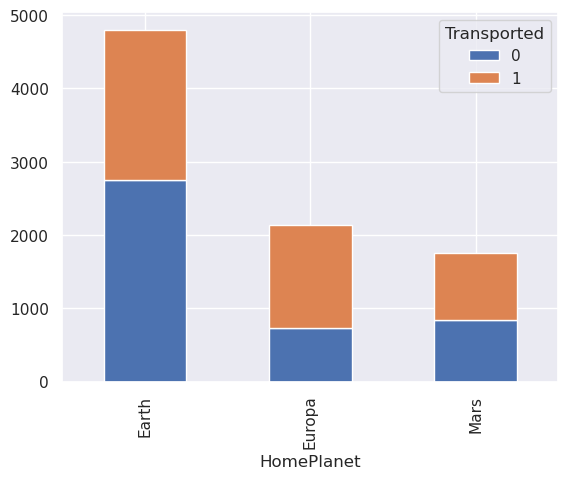

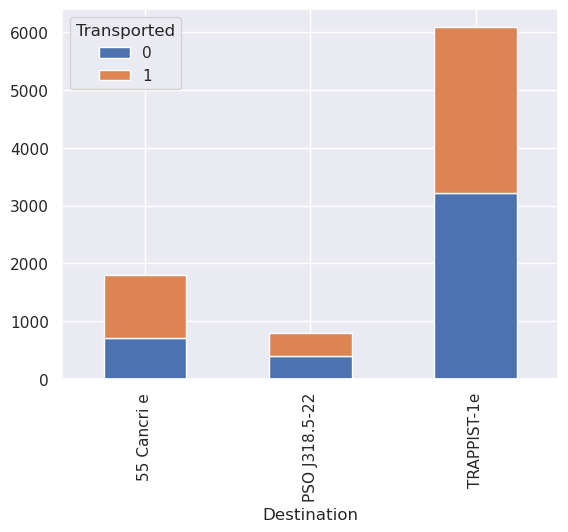

In [89]:
# Create a crosstab of the number of transported individuals from each home planet
transported_by_homeplanet = pd.crosstab(index=X['HomePlanet'], columns=y)

# Create a crosstab of the number of transported individuals to each destination
transported_by_destination = pd.crosstab(index=X['Destination'], columns=y)

# Plot a stacked bar chart of the number of transported individuals from each home planet
transported_by_homeplanet.plot(kind='bar', stacked=True)

# Plot a stacked bar chart of the number of transported individuals to each destination
transported_by_destination.plot(kind='bar', stacked=True)

Check ditribution of those transported by cabin number

In [90]:
ohe_cat_cols = [col for col in X if
           (X[col].dtype == 'object')]
            


In [91]:
X = pd.get_dummies(X, columns = ohe_cat_cols)

In [92]:
# split data
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.2, random_state = 1)

In [94]:
from sklearn.linear_model import LogisticRegression
f_model = LogisticRegression(solver = 'lbfgs', random_state = 1, max_iter = 5000)
f_model.fit(X_train, y_train)
prediction = f_model.predict(X_valid)
accuracy_score(y_valid, prediction)

0.7975848188614146

In [98]:
# Read the test data from CSV
test_X = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# Fill missing values in the test data
for col in num_cols:
    test_X[col] = test_X[col].fillna(test_X[col].mean())

for col in cat_cols:
    test_X[col] = test_X[col].fillna(test_X[col].mode().iloc[0])

# Preprocess the test data: convert categorical columns to numerical values
test_X["CryoSleep"] = test_X["CryoSleep"].astype(int)
test_X["VIP"] = test_X["VIP"].astype(int)

test_X = test_X.drop(["Name"], axis = 1)
test_X = test_X.drop(["PassengerId"], axis = 1)

test_X = pd.get_dummies(test_X, columns=['HomePlanet', 'Cabin', 'Destination'])

# Align the test data columns with the training data columns
test_X = test_X.reindex(columns=X.columns, fill_value=0)

# Make predictions on the test data
test_predictions = f_model.predict(test_X)

In [100]:
# Create a submission DataFrame 
submission = pd.DataFrame({'Cabin': test_df['Cabin'], 'Transported': test_predictions})

# Save the submission to a CSV file
submission.to_csv('sample_submission.csv', index=False)